In [1]:
req = """# Python 3.7.5
onnx>=1.7.0
numpy>=1.19.1

torch>=1.8.1
torchvision>=0.9.1

tensorflow>=2.1.0
tensorflow-gpu>=2.1.0"""

f = open("requirements.txt", "w")
f.write(req)
f.close()

In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 804.1 MB 2.2 kB/s 
     |████████████████████████████████| 17.4 MB 35.9 MB/s 
     |████████████████████████████████| 454.3 MB 14 kB/s 
     |████████████████████████████████| 394.3 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.1
    Uninstalling torchvision-0.8.1:
      Successfully uninstalled torchvision-0.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.3.0 requires torch<1.8,>=1.7.0, but you have torch 1.8.1 which is incompatible.
fastai 2.3.0 requires torchvision<0.9,>=0.8, but you have torchvision 0.9.1 which is incompatible.


In [3]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=04801c45821499e27a1770ed20905935a3f58c8f728e13092ed56e9f9f5916a9
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [4]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import widerface
import tensorflow_datasets.public_api as tfds
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import os
import copy
import pandas
import requests
import zipfile
from math import ceil
from math import floor
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.8.1+cu102
Torchvision Version:  0.9.1+cu102


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
torch.manual_seed(1)

In [7]:
batch_size_train = 5
batch_size_val = 1
batch_size_test = 1
num_classes = 1
num_cells = 49
num_boxes_per_cell = 4
img_dim = 224
epochs = 8

def detection_collate(batch):
    """Custom collate fn for dealing with batches of images that have a different
    number of associated object annotations (bounding boxes).
    Arguments:
      batch: (tuple) A tuple of tensor images and lists of annotations
    Return:
      A tuple containing:
          1) (tensor) batch of images stacked on their 0 dim
          2) (list of tensors) annotations for a given image are stacked on 0 dim
    """
    transform_resize = transforms.Resize((img_dim, img_dim))
    targets = []
    imgs = []
    for _, sample in enumerate(batch):
        img, annot = sample
        target = torch.tensor(annot['bbox']).float()
        if target.shape[0] < 11: #drop images with too many targets : too hard
            orig_h = img.shape[1]
            orig_w = img.shape[2]
            img = transform_resize(img)

            target[:,0] = target[:,0] / orig_w * img_dim
            target[:,2] = target[:,2] / orig_w * img_dim

            target[:,1] = target[:,1] / orig_h * img_dim
            target[:,3] = target[:,3] / orig_h * img_dim

            mt = torch.mean(target, dim=0)
            if mt[2] * mt[3] > 400: # drop images with too small targets (w*h < 20*20)
                imgs.append(img)
                targets.append(target)

    imgs_t = None
    targets_t = None
    if len(imgs) > 0 and len(targets) > 0:
        imgs_t = torch.stack(imgs, 0)
        targets_t = targets

    return (imgs_t, targets_t)

In [8]:
widerface_path = '/kaggle/input/'
#widerface_path = './'
train_loader = torch.utils.data.DataLoader(
  datasets.WIDERFace(widerface_path, "train", download=False,
                             transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                             ])),
  batch_size=batch_size_train, shuffle=True, collate_fn=detection_collate)

val_loader = torch.utils.data.DataLoader(
  datasets.WIDERFace(widerface_path, "val", download=True,
                              transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                             ])),
  batch_size=batch_size_val, shuffle=True, collate_fn=detection_collate)

test_loader = torch.utils.data.DataLoader(
  datasets.WIDERFace(widerface_path, "test", download=True,
                             transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                             ])),
  batch_size=batch_size_test, shuffle=True, collate_fn=detection_collate)



Files already downloaded and verified
Files already downloaded and verified


79.40625 49.4196662902832 19.25 54.25419616699219
120.3125 47.27098083496094 17.71875 53.71702575683594
132.5625 29.007192611694336 13.5625 40.8249397277832


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


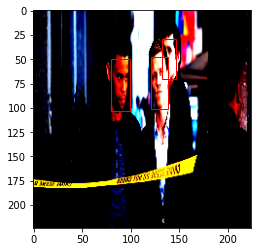

In [9]:
images = None
targets = None

while images is None or targets is None:
    images, targets = next(iter(train_loader))

fig, ax = plt.subplots()

ax.imshow(images[0].permute(1, 2, 0))

num_targets = targets[0].shape[0]
for i in range(num_targets):
    #x,y represent bottom left corner
    x = targets[0][i][0]
    y = targets[0][i][1]
    w = targets[0][i][2]
    h = targets[0][i][3]
    print("{} {} {} {}".format(x, y, w, h))
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

In [10]:
def intersect(box_a, box_b):
    """ 
    We compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """

    max_xy = torch.min(box_a[:, 2:] + box_a[:, :2], box_b[:, 2:] +  box_b[:, :2])
    min_xy = torch.max(box_a[:, :2], box_b[:, :2])

    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Pred box Shape: [4]
    Return:
        
    """
    inter = intersect(box_a, box_b)
    area_a = box_a[:, 2] * box_a[:, 3]  # [A,B]
    area_b = box_b[:, 2] * box_b[:, 3]  # [A,B]
    union = area_a + area_b - inter
    return inter / (union + 1e-10)  # [A,B]

In [11]:
def index_select_2D(input, dim, indexes, by=1):
    """
        like index_select but with indexes with more than one dim
        example :
          x=torch.randn((2,3,2))
          i = torch.randint(2, (2,3,1))
          index_select_2D(x, -1, i)
          will select in the last dimension (2) with the value in i
          and output a tensor of shape (2, 3)

          x=torch.randn((2,3,2,4))
          i = torch.randint(2, (2,3,1))
          index_select_2D(x, -2, i, by=4)
          will select (whole row, 4 by 4) along the dimension (2) with the value in i
          and output a tensor of shape (2, 3, 4)

          NOTE : indexes must have the same number of dimension as input
      """
    if by > 1:
        indexes = torch.stack([indexes]*by, dim=-1)
    return torch.gather(input, dim, indexes).squeeze(2)


In [12]:
class ResnetGrid7x7(nn.Module):
    def __init__(self, resnet=models.resnet18(pretrained=True)):
        super(ResnetGrid7x7, self).__init__()
        self.resnet = resnet
        self.resnet.fc = nn.Linear(512, num_cells*(num_classes+num_boxes_per_cell*5)) # 7 * 7 * (class + 2 * (x,y,w,h + confidence))
        self.sigmo = nn.Sigmoid()

    def forward(self, x):
        return self.sigmo(self.resnet(x))
    
    def train(self, mode: bool=True):
        self.resnet.train(mode)

    def eval(self):
        self.resnet.eval()

    def freeze_resnet(self, mode: bool=True):
        for param in self.resnet.parameters():
            param.require_grad = not mode


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
class EffnetGrid7x7(nn.Module):
    def __init__(self, resnet=EfficientNet.from_pretrained('efficientnet-b0')):
        super(EffnetGrid7x7, self).__init__()
        self.resnet = resnet
        self.fc = nn.Linear(1000, num_cells*(num_classes+num_boxes_per_cell*5)) # 7 * 7 * (class + 2 * (x,y,w,h + confidence))
        self.sigmo = nn.Sigmoid()

    def forward(self, x):
        x = self.resnet(x)
        return self.sigmo(self.fc(x))
    
    def train(self, mode: bool=True):
        self.resnet.train(mode)

    def eval(self):
        self.resnet.eval()

    def freeze_resnet(self, mode: bool=True):
        for param in self.resnet.parameters():
            param.require_grad = not mode

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [14]:
class PseudoYolo7x7Loss(nn.Module):
    def __init__(self, noobj_w=1.0, class_w=1.0, conf_w=1.0, box_w=1.0):
        super(PseudoYolo7x7Loss, self).__init__()
        self.class_w = class_w
        self.conf_w = conf_w
        self.box_w = box_w
        self.noobj_w = noobj_w
        self.sse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()

        #Coords of each cells
        self.cell_x = torch.empty(num_cells).int().to(device)
        self.cell_y = torch.empty(num_cells).int().to(device)
        for i in range(num_cells):
            self.cell_x[i] = floor(i % 7) * 32
            self.cell_y[i] = floor(i / 7) * 32


    def getResponsibleCells(self, targets):
        """  
        return a tuple of tensor:
        - is_responsible, of size (batch_size, num_targets, num_cells)
          which contain the target confidence (0 or 1) for each cell (basically if
          the cell is responsible of at least one target bounding box, it will have a 1)
        - targets_box of size (batch_size, num_cells, 4)
          which contains for each cell, the target bounding box it is responsible of
        """

        batch_size = len(targets)

        # This limit the number of,  detectable targets to the first 10 targets
        num_lim_targets = 10
        lim_targets = - torch.ones(batch_size, num_lim_targets, 4).float().to(device)
        for b in range(batch_size):
            num_targets = targets[b].shape[0]
            # even with overflow index, pytorch doesn't error, good
            lim_targets[b, :num_targets] = targets[b][:num_lim_targets]

        # Calculates centers of target boxes
        center_xs = lim_targets[:, :, 0] + lim_targets[:, :, 2]/2
        center_ys = lim_targets[:, :, 1] + lim_targets[:, :, 3]/2
        # make it broadcastable with cell_x and cell_y
        center_xs = center_xs.unsqueeze(2).expand(-1, -1, num_cells)
        center_ys = center_ys.unsqueeze(2).expand(-1, -1, num_cells)

        # is_responsible contains for each targets (rows) if cells is responsible (columns)
        is_responsible_x = torch.logical_and(self.cell_x <= center_xs, center_xs <= self.cell_x + 32)
        is_responsible_y = torch.logical_and(self.cell_y <= center_ys, center_ys <= self.cell_y + 32)
        is_responsible = torch.logical_and(is_responsible_x, is_responsible_y)  

        # https://pytorch.org/docs/stable/generated/torch.nonzero.html
        batch_indexes,target_indexes,cell_indexes = is_responsible.nonzero(as_tuple=True)

        #resize to range [0. 1.]
        lim_targets = lim_targets / img_dim

        # batch_size * (49 rows of (.5,.5,.5,.5))
        targets_boxes = torch.tensor((.5,.5,.5,.5)).expand((batch_size, num_cells, 4)).to(device)
        # Pytorch indexing is just magical...
        targets_boxes[batch_indexes, cell_indexes, :] = lim_targets[batch_indexes, target_indexes, :]

        #(batch_size, num_targets, num_cells) (batch_size, num_cells, 4)
        return is_responsible, targets_boxes

    def prepareBoxes(self, preds_boxes, targets_boxes):
        preds_boxes_xy, preds_boxes_wh = torch.split(preds_boxes, 2, dim=-1)
        targets_boxes_xy, targets_boxes_wh = torch.split(targets_boxes, 2, dim=-1)

        # predict box center_x, center_y relative to cell_x, and cell_y
        cell_xy = torch.stack([self.cell_x, self.cell_y], dim=-1)
        targets_centers = (targets_boxes_xy + targets_boxes_wh / 2.)
        targets_boxes_xy =  targets_centers - cell_xy / img_dim

        # predict square root of w and h. Otherwise loss function would advantage
        # small boxes
        preds_boxes_wh = preds_boxes_wh.sqrt()
        targets_boxes_wh = targets_boxes_wh.sqrt()

        # reunite
        preds_boxes = torch.cat([preds_boxes_xy, preds_boxes_wh], dim=-1)
        targets_boxes = torch.cat([targets_boxes_xy, targets_boxes_wh], dim=-1)

        return preds_boxes, targets_boxes

    def sseLoss(self, preds, targets, weights=1.0):
        return torch.sum(weights * ((preds - targets) * (preds - targets)), dim=1).mean()

    def forward(self, predictions, targets):
        preds = predictions.view(-1, num_cells, num_classes+num_boxes_per_cell*5)
        batch_size = preds.shape[0]

        # (batch, cells, (class + boxes * (x,y,w,h + confidence))
        preds_class = preds[:,:,0] #(batch, cells, class(1))
        preds_conf_and_boxes = preds[:,:,1:].view(-1, num_cells, num_boxes_per_cell, 5)
        preds_confs = preds_conf_and_boxes[:, :, :, 0] #(batch, cells, boxes)
        preds_boxes = preds_conf_and_boxes[:, :, :, 1:] #(batch, cells, boxes, 4)

        # print("A ", preds_confs.shape, preds_boxes.shape)

        is_responsible, targets_boxes = self.getResponsibleCells(targets)

        ious = []
        for i in range(num_boxes_per_cell):
            pb = preds_boxes[:,:,i,:]
            iou_bi = jaccard(targets_boxes.view(-1, 4), pb.contiguous().view(-1, 4))
            iou_bi = iou_bi.view(targets_boxes.shape[0], targets_boxes.shape[1]) #(batch, cells)
            ious.append(iou_bi)
        iou = torch.stack(ious, dim=-1) #(batch, cells, boxes)

        max_iou_indexes = torch.argmax(iou, dim=-1, keepdim=True)

        # print("max ", max_iou_indexes.shape)

        # For each cell, select the box and conf with max IoU
        preds_confs = index_select_2D(preds_confs, -1, max_iou_indexes)
        preds_boxes = index_select_2D(preds_boxes, -2, max_iou_indexes, by=4)

        # print("B ", preds_confs.shape, preds_boxes.shape)

        # w, h are to be evaluated to their sqrt (advantages little boxes otherwise)
        # preds x, y are to be evaluated as center of box and relative to the cell x,y
        preds_boxes, targets_boxes = self.prepareBoxes(preds_boxes, targets_boxes)

        # calculate box loss only for if a the cell is responsible. This zeros the loss otherwise
        ir_reduced = (torch.sum(is_responsible, 1) > 0).float().detach()
        #targets_boxes.masked_scatter_(torch.logical_not(cr_reduced.bool()).unsqueeze(-1).expand_as(targets_boxes),
        #                              preds_boxes)

        # If an object is not detected, weight down the conf loss
        noobj_w = (1 - ir_reduced) * self.noobj_w + ir_reduced
        box_noobj_w = ir_reduced.unsqueeze(-1).expand(-1, 49, 4)
        coonf_noobj_w = ir_reduced
                
        class_loss = self.class_w * self.sseLoss(preds_class, ir_reduced, noobj_w)
        box_loss = self.box_w * self.sseLoss(preds_boxes, targets_boxes, box_noobj_w)
        conf_loss = self.conf_w * self.sseLoss(preds_confs, ir_reduced, coonf_noobj_w)


        return class_loss + box_loss + conf_loss

In [15]:
#model = ResnetGrid7x7()
model = EffnetGrid7x7()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=5e-4)
criterion = PseudoYolo7x7Loss(noobj_w=0.5, box_w=5.0, conf_w=0.5, class_w=1.0)

In [16]:
# get pretrained from this notebook
#r = requests.get("https://github.com/law0/face_detect/raw/main/face_detect_resnet18_state_dict.pth", allow_redirects=True)
#open("face_detect_resnet18_state_dict.pth", "wb").write(r.content)
#if os.path.isfile("./face_detect_resnet18_state_dict.pth"):
#    model.load_state_dict(torch.load("./face_detect_resnet18_state_dict.pth"))

------------------------------- epoch  0  --------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


9.1001
mean 0.49692535400390625, min 0.316753089427948, max 0.669605553150177


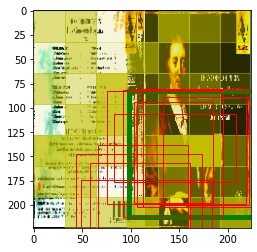

1.1534
mean 0.050777092576026917, min 0.005995047744363546, max 0.5667686462402344


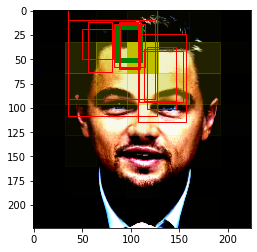

0.5553
mean 0.035641420632600784, min 0.0028568669222295284, max 0.31080740690231323


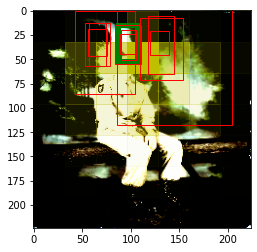

0.9182
mean 0.06612955778837204, min 0.006519277114421129, max 0.3882195055484772


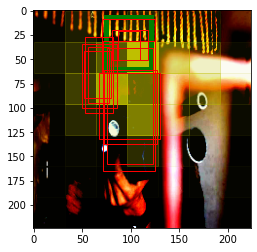

1.2891
mean 0.040123119950294495, min 0.0026107856538146734, max 0.4188075363636017


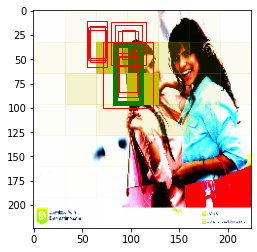

2.2245
mean 0.09471394866704941, min 0.00793594028800726, max 0.49175894260406494


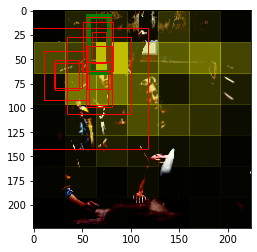

------------------------------- epoch  1  --------------------------------
0.9370
mean 0.06873320788145065, min 0.00787845067679882, max 0.7948044538497925


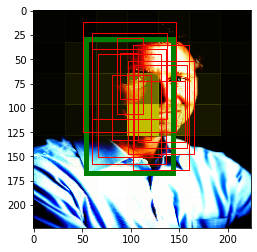

1.0979
mean 0.07141568511724472, min 0.004954239819198847, max 0.8534976243972778


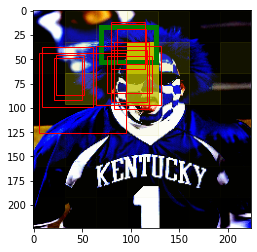

2.0997
mean 0.04221438243985176, min 0.0018294703913852572, max 0.26448285579681396


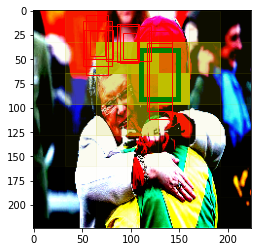

0.6244
mean 0.09196600317955017, min 0.0069037857465445995, max 0.6588977575302124


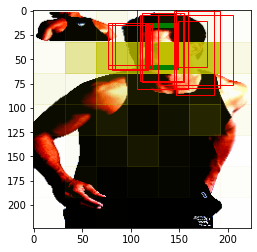

5.8106
mean 0.05229397490620613, min 0.008436666801571846, max 0.3805016577243805


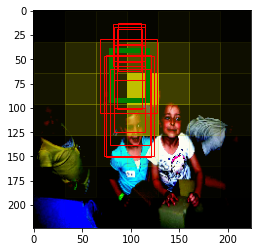

1.0622
mean 0.0704428106546402, min 0.0036811786703765392, max 0.6934161186218262


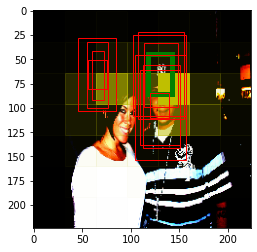

------------------------------- epoch  2  --------------------------------
0.3827
mean 0.05625194311141968, min 0.006300643552094698, max 0.8678907155990601


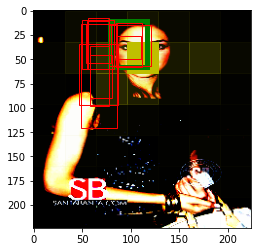

2.1914
mean 0.029873982071876526, min 0.003245067084208131, max 0.16792361438274384


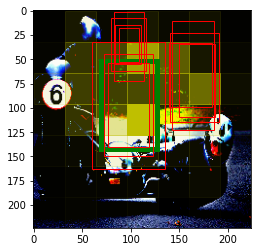

0.7751
mean 0.053001776337623596, min 0.012580493465065956, max 0.4079582393169403


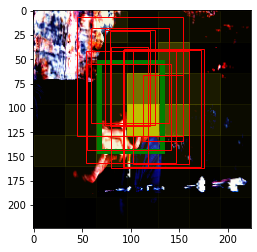

1.1169
mean 0.04743252694606781, min 0.004571687430143356, max 0.4095515310764313


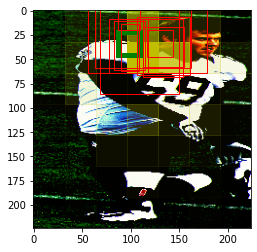

0.0891
mean 0.04469733312726021, min 0.00627178605645895, max 0.9665642380714417


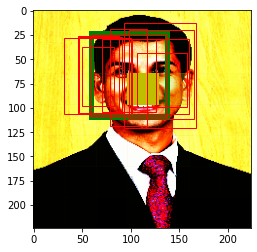

2.2040
mean 0.07388479262590408, min 0.006710893474519253, max 0.6771106123924255


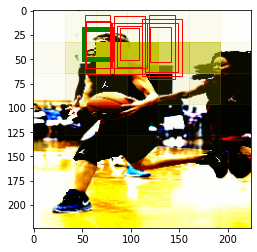

------------------------------- epoch  3  --------------------------------
0.2646
mean 0.05765819549560547, min 0.002228714060038328, max 0.396390438079834


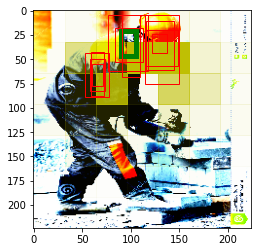

0.8162
mean 0.03620389103889465, min 0.0026906479615718126, max 0.6872291564941406


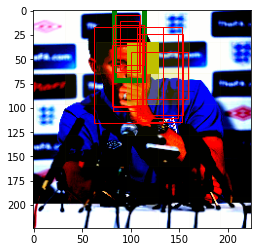

1.2643
mean 0.11526226252317429, min 0.004454412497580051, max 0.9620707035064697


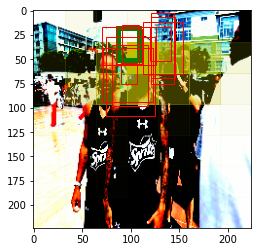

2.6083
mean 0.09996449202299118, min 0.020593823865056038, max 0.4759892523288727


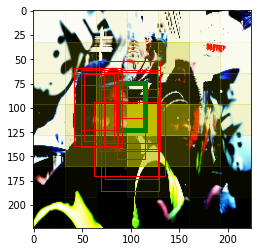

0.4134
mean 0.0652918741106987, min 0.006412537768483162, max 0.6698477864265442


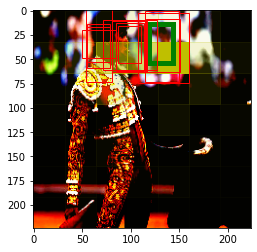

0.5636
mean 0.10366309434175491, min 0.008265693672001362, max 0.7052423357963562


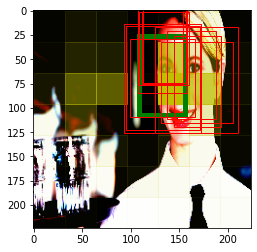

------------------------------- epoch  4  --------------------------------
0.9758
mean 0.05762375518679619, min 0.0016600366216152906, max 0.5522950887680054


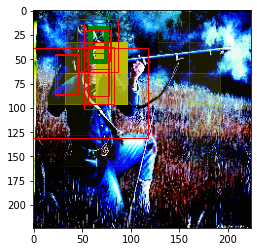

0.7576
mean 0.04616597294807434, min 0.0013035795418545604, max 0.9110974073410034


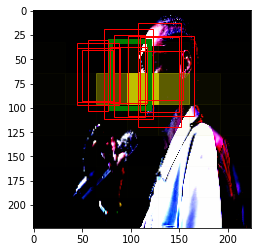

0.2833
mean 0.05419176444411278, min 0.0006685768021270633, max 0.9565993547439575


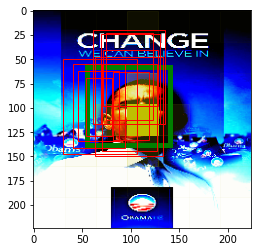

1.8889
mean 0.0579824224114418, min 0.005006035789847374, max 0.5078710913658142


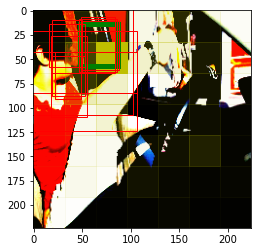

0.8293
mean 0.030781937763094902, min 0.0004649058391805738, max 0.9927720427513123


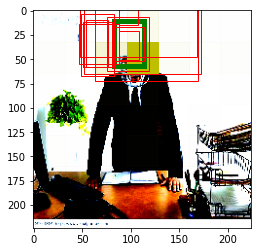

0.3613
mean 0.03437690809369087, min 0.00043832563096657395, max 0.8837448954582214


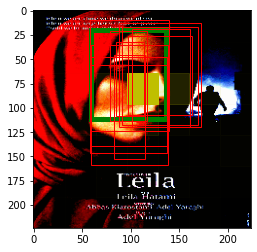

------------------------------- epoch  5  --------------------------------
1.3331
mean 0.04330521449446678, min 0.0027682040818035603, max 0.2052503228187561


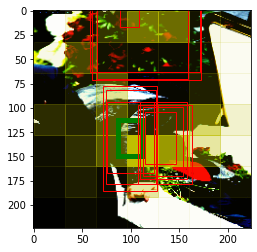

1.1357
mean 0.05049211159348488, min 0.0005163914174772799, max 0.9799935817718506


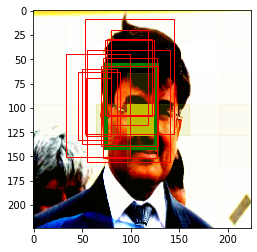

1.2390
mean 0.09650115668773651, min 0.0025418519508093596, max 0.6860608458518982


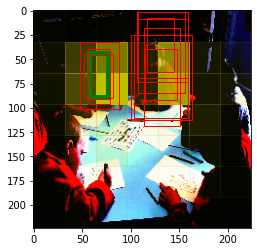

1.4659
mean 0.04665519669651985, min 0.004552395548671484, max 0.5084570050239563


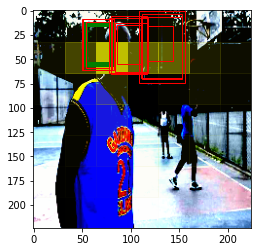

1.6712
mean 0.0717388167977333, min 0.0012952800607308745, max 0.6951308250427246


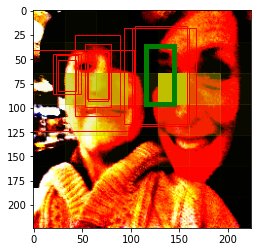

1.3032
mean 0.05635411664843559, min 0.0003664969408418983, max 0.32053342461586


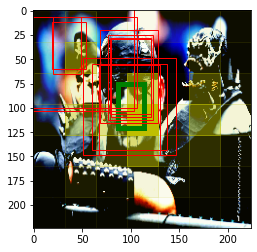

------------------------------- epoch  6  --------------------------------
0.7139
mean 0.05727468430995941, min 0.0006596114835701883, max 0.2911926507949829


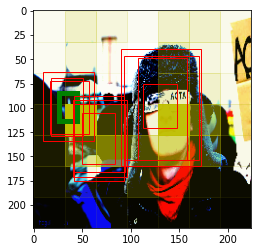

1.5705
mean 0.09120236337184906, min 0.009818607941269875, max 0.8499391674995422


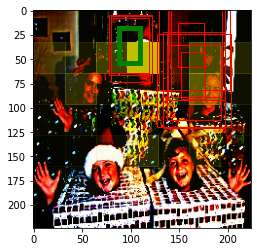

0.7712
mean 0.04840419813990593, min 0.0019379163859412074, max 0.9668763875961304


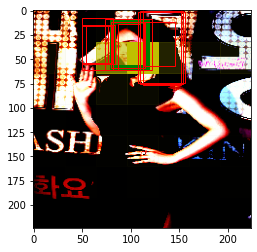

1.1351
mean 0.10875245183706284, min 0.0015720878727734089, max 0.9763679504394531


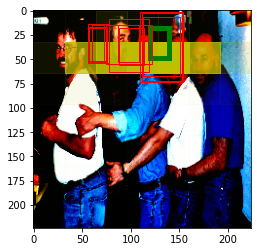

0.3704
mean 0.03317228704690933, min 2.1393614588305354e-05, max 0.9856448173522949


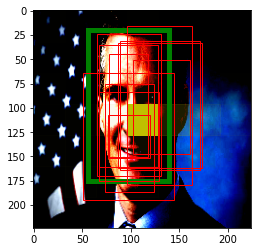

1.0223
mean 0.019039416685700417, min 0.00017109319742303342, max 0.7805516123771667


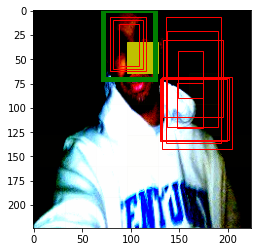

------------------------------- epoch  7  --------------------------------
0.1077
mean 0.02354944683611393, min 0.0003675487532746047, max 0.9212875962257385


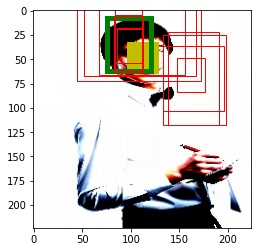

0.0117
mean 0.031302742660045624, min 0.0011091431370005012, max 0.968329668045044


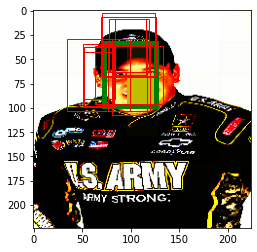

0.0348
mean 0.02615128830075264, min 0.000507407239638269, max 0.8444327116012573


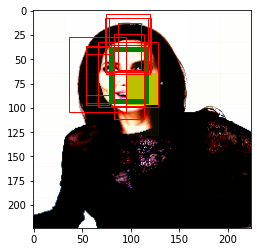

0.5730
mean 0.024306228384375572, min 3.421783912926912e-05, max 0.994468092918396


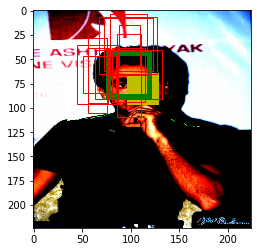

0.7617
mean 0.044282007962465286, min 0.00026523208362050354, max 0.9588919281959534


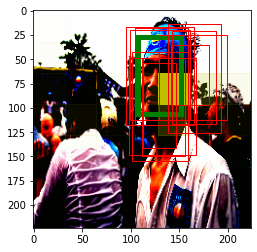

In [17]:
loss_over_time = []

model.to(device)
model.train(True)

images = None
targets = None
t = []

#while images is None or targets is None:
#    images, targets = next(iter(train_loader))
#    t.append((images, targets))
    
#images = None
#targets = None
    
#while images is None or targets is None:
#    images, targets = next(iter(train_loader))
#    t.append((images, targets))
time_start = time.time()
for ep in range(epochs):
    if time.time() - time_start > 3 * 60 * 60:
        break
    print("------------------------------- epoch ", ep, " --------------------------------")
    for i, (images, targets) in enumerate(train_loader):
    #for i, (images, targets) in enumerate(t * 1000):
        if images is None or targets is None:
            continue
        images = images.to(device)
        targets = [anno.to(device) for anno in targets]

        optimizer.zero_grad()

        out = model(images)
        loss = criterion(out, targets)
        loss.backward()
        optimizer.step()

        if i % 500 == 0:
        #if i > 997:
            loss = loss.cpu()
            print("{:.4f}".format(loss.item()))
            loss_over_time.append(loss.item())

        #if i % 100 == 0:
            preds = out.view(-1, num_cells, num_classes+num_boxes_per_cell*5)
            classes = preds[0,:,0]
            conf_and_boxes = preds[0, :, 1:]

            min_class = torch.min(classes).item()
            max_class = torch.max(classes).item()
            range_class = max_class - min_class
            
            print("mean {}, min {}, max {}".format(classes.mean().item(), min_class, max_class))

            max_class_indexes = torch.argsort(classes, descending=True)

            fig, ax = plt.subplots()
            im = images[0].permute(1, 2, 0).cpu()
            ax.imshow(im)

            rects = []

            for c in range(49):
                cell = max_class_indexes[c]
                cell_pred = conf_and_boxes[cell, :].view(num_boxes_per_cell, 5)
                cell_x = floor(cell % 7) * 32
                cell_y = floor(cell / 7) * 32

                # color responsible cell
                rect = patches.Rectangle((cell_x, cell_y), 32, 32, linewidth=1, edgecolor='y', facecolor='y', fill=True, 
                                         alpha=((classes[cell] - min_class) / range_class).item())
                ax.add_patch(rect)

                if c < 3:
                    for b in range(num_boxes_per_cell):
                        conf = cell_pred[b, 0] #(boxes, 1)
                        box = cell_pred[b, 1:] #(boxes, 4)

                        w = box[2] * img_dim
                        h = box[3] * img_dim
                        x = box[0] * 32 + cell_x - w / 2.
                        y = box[1] * 32 + cell_y - h / 2.

                        #print("class {}, confidence {}, box: {} {} {} {}".format(classes[cell].item(), conf.item(), x, y, w, h))
                        rects.append((x, y, w, h, classes[cell].item() * conf.item()))
                    
            rects = sorted(rects, key=lambda t: t[4], reverse=True)

            if len(rects) > 0:
                # most confident in green
                rect = patches.Rectangle((rects[0][0], rects[0][1]), rects[0][2], rects[0][3], linewidth=5, edgecolor='g', facecolor='none')
                ax.add_patch(rect)

                # rest in red
                for i in range(1, len(rects)):
                    rect = patches.Rectangle((rects[i][0], rects[i][1]), rects[i][2], rects[i][3], linewidth=1, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)     

            plt.show()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


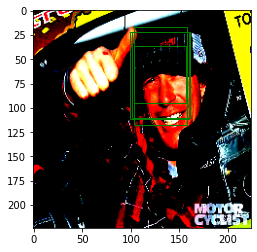

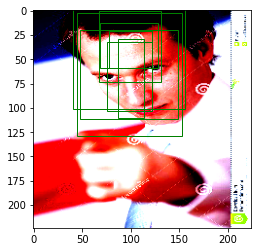

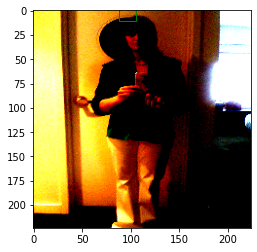

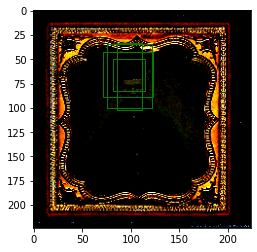

In [18]:
model.train(False)
model.eval()

for i, (images, targets) in enumerate(val_loader):
    if images is None or targets is None:
        continue
    images = images.to(device)
    targets = [anno.to(device) for anno in targets]

    out = model(images)

    preds = out.view(-1, num_cells, num_classes+num_boxes_per_cell*5)
    for b in range(preds.shape[0]): # batch
        classes = preds[b,:,0]
        conf_and_boxes = preds[b, :, 1:].view(num_cells, num_boxes_per_cell, 5)

        fig, ax = plt.subplots()
        im = images[b].permute(1, 2, 0).cpu()
        ax.imshow(im)

        for c in range(49): # cell
            classe = classes[c]
            cell_x = floor(c % 7) * 32
            cell_y = floor(c / 7) * 32
            if classe > 0.5:
                for bc in range(num_boxes_per_cell): # boxes
                    conf = conf_and_boxes[c, bc, 0]
                    box = conf_and_boxes[c, bc, 1:]

                    if conf > 0.5:                    
                        w = box[2] * img_dim
                        h = box[3] * img_dim
                        x = box[0] * 32 + cell_x - w / 2.
                        y = box[1] * 32 + cell_y - h / 2.

                        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
                        ax.add_patch(rect)
    
    plt.show()
    if i >= 10:
        break
                            
                            
                    
                

In [19]:
#torch.save(model.state_dict(), './face_detect_resnet18_state_dict.pth')
#torch.save(model, './face_detect_resnet18_whole.pth')
torch.save(model.state_dict(), './face_detect_effnetb0_state_dict.pth')
torch.save(model, './face_detect_effnetb0_whole.pth')

In [20]:
# define the directory for further converted model save
onnx_model_path = "./"
# define the name of further converted model
#onnx_model_name = "YoloResnet18.onnx"
onnx_model_name = "YoloEffnetb0.onnx"
# create directory for further converted model
os.makedirs(onnx_model_path, exist_ok=True)
# get full path to the converted model
full_model_path = os.path.join(onnx_model_path, onnx_model_name)
# generate model input
generated_input = Variable(
    torch.randn(1, 3, 224, 224)
)

model.to(torch.device('cpu'))
model.resnet.set_swish(memory_efficient=False)

# model export into ONNX format
torch.onnx.export(
    model,
    generated_input,
    full_model_path,
    verbose=True,
    input_names=["input"],
    output_names=["output"],
    opset_version=11
)

print("Success")

graph(%input : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cpu),
      %resnet._blocks.0._se_reduce.weight : Float(8, 32, 1, 1, strides=[32, 1, 1, 1], requires_grad=1, device=cpu),
      %resnet._blocks.0._se_reduce.bias : Float(8, strides=[1], requires_grad=1, device=cpu),
      %resnet._blocks.0._se_expand.weight : Float(32, 8, 1, 1, strides=[8, 1, 1, 1], requires_grad=1, device=cpu),
      %resnet._blocks.0._se_expand.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %resnet._blocks.1._se_reduce.weight : Float(4, 96, 1, 1, strides=[96, 1, 1, 1], requires_grad=1, device=cpu),
      %resnet._blocks.1._se_reduce.bias : Float(4, strides=[1], requires_grad=1, device=cpu),
      %resnet._blocks.1._se_expand.weight : Float(96, 4, 1, 1, strides=[4, 1, 1, 1], requires_grad=1, device=cpu),
      %resnet._blocks.1._se_expand.bias : Float(96, strides=[1], requires_grad=1, device=cpu),
      %resnet._blocks.2._se_reduce.weight : Float(6, 144, 1,